# Training a Neural Network for Computer Model Emulation

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [4]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [5]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

#perform a transformation of the design, swapping the original parameters
#for inputs more naturally/simply related to the outputs
do_transform_design = True
if do_transform_design:
    X = transform_design(X.values)

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)

Y = np.array([])
for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
        
Y = Y.reshape(X.shape[0], -1)

In [6]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 29)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

feature_range = (-1, 1)

X_scaler = MinMaxScaler(feature_range = feature_range ).fit(X_train)
Y_scaler = MinMaxScaler(feature_range = feature_range ).fit(Y_train)
#X_scaler = StandardScaler().fit(X_train)
#Y_scaler = StandardScaler().fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

### The cell below constructs the neural network

In [8]:
from keras.models import Model

n_neur = 100 #number of neurons on hidden layers
dropout_rate = 0.3 # the layer dropout rate 
noise_level = 0.05 #noise level in training data

gamma_rbf = np.ones(X.shape[1])

def build_model():
    
    inputs = layers.Input(shape=(X.shape[1],))
    #x = layers.Dense(n_neur, activation='tanh')(inputs)
    x = layers.experimental.RandomFourierFeatures(n_neur, kernel_initializer='gaussian', trainable=True)(inputs)
    #x = layers.Dropout(dropout_rate)(x, training=True)
    x = layers.Dense(n_neur)(x)
    x = layers.GaussianDropout(dropout_rate)(x, training=True)
    x = layers.Dense(Y.shape[1], activation='tanh')(x)
    x = layers.GaussianDropout(0.1)(x, training=True)
    
    #x = layers.GaussianNoise(noise_level)(x)
    
    outputs = x
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='huber_loss', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
random_fourier_features (Ran (None, 100)               3001      
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               11110     
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, 110)               0         
Total params: 24,211
Trainable params: 21,211
Non-trainable params: 3,000
______________________________________________

In [9]:
model.fit(X_train_sc, Y_train_sc, epochs=500, batch_size=50, verbose=0)

In [10]:
predictions = []
nsamples_pred = 100
for t in range(nsamples_pred):
    predictions.append(model.predict(X_test_sc))

pred_array = np.array(predictions)
pred_mean = np.mean(pred_array,axis=0)
pred_std  = np.std(pred_array,axis=0)

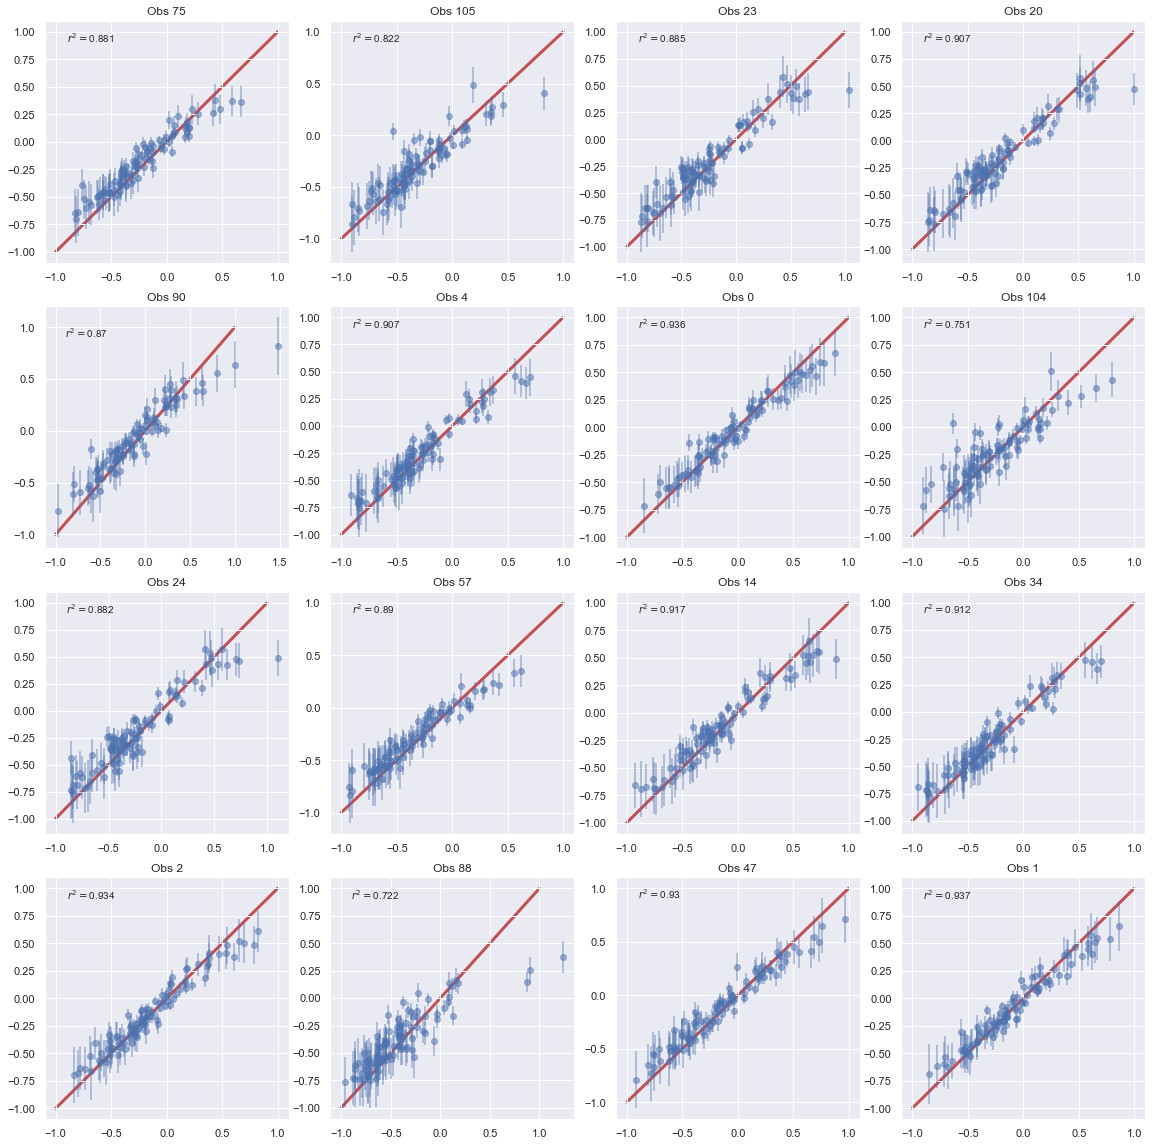

In [11]:
truth = np.linspace(-1, 1, 100)

sqrt_nplot = 4
n_plot = sqrt_nplot * sqrt_nplot
obs_indices = np.random.choice(110, n_plot, replace=False)

fig, axes = plt.subplots(sqrt_nplot, sqrt_nplot, figsize=(4*sqrt_nplot, 4*sqrt_nplot))
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title("Obs " + str(obs_ind))
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind], yerr=pred_std[:, obs_ind],
                alpha=0.5, zorder=1, fmt='o')
    r2 = r2_score(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind])
    ax.annotate(r'$r^2 = $' + str(round(r2, 3) ), xy = (-0.9, 0.9))
plt.tight_layout(True)
plt.show()

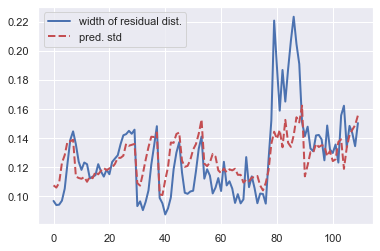

In [12]:
sigma_res_arr = []
sigma_pred_arr = []

for iobs in range(Y.shape[1]):
    res =  pred_mean[:, iobs] - Y_test_sc[:, iobs]
    sigma_res = np.std(res)
    sigma_pred = np.mean(pred_std[:, iobs])
    sigma_res_arr.append(sigma_res)
    sigma_pred_arr.append(sigma_pred)


plt.plot(np.arange(0, Y.shape[1]), sigma_res_arr, lw=2, label='width of residual dist.')
plt.plot(np.arange(0, Y.shape[1]), sigma_pred_arr, lw=2, color='r', label='pred. std', ls='--')
plt.legend()
plt.show()

In [13]:
r2 = r2_score(Y_test_sc,pred_mean)
print("r2 = " + str(round(r2, 3)))

r2 = 0.875
